# 7. Dev Sets, Early Stopping and Saves

### About this notebook

This notebook was used in the 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Matthieu DE MARI (matthieu_demari@sutd.edu.sg)

**Version:** 1.0 (17/12/2022)

**Requirements:**
- Python 3 (tested on v3.9.6)
- Matplotlib (tested on v3.5.1)
- Numpy (tested on v1.22.1)
- Pickle (part of the Python library)

### Imports

In [214]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Numpy
import numpy as np
from numpy.random import default_rng
# OS
import os
# Pickle
import pickle
# Removing unecessary warnings (optional, just makes notebook outputs more readable)
import warnings
warnings.filterwarnings("ignore")

### Mock dataset, with nonlinearity

As in the previous notebook.

In [152]:
# All helper functions
eps = 1e-5
min_val = -1 + eps
max_val = 1 - eps
def val(min_val, max_val):
    return round(np.random.uniform(min_val, max_val), 2)
def class_for_val(val1, val2):
    k = np.pi
    return int(val2 >= -1/4 + 3/4*np.sin(val1*k))
n_points = 1000
def create_dataset(n_points, min_val, max_val):
    val1_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    val2_list = np.array([val(min_val, max_val) for _ in range(n_points)])
    inputs = np.array([[v1, v2] for v1, v2 in zip(val1_list, val2_list)])
    outputs = np.array([class_for_val(v1, v2) for v1, v2 in zip(val1_list, val2_list)]).reshape(n_points, 1)
    return val1_list, val2_list, inputs, outputs

In [153]:
# Generate dataset
np.random.seed(47)
val1_list, val2_list, inputs, outputs = create_dataset(n_points, min_val, max_val)
# Check a few entries of the dataset
print(val1_list.shape)
print(val2_list.shape)
print(inputs.shape)
print(outputs.shape)
print(inputs[0:10, :])
print(outputs[0:10])

(1000,)
(1000,)
(1000, 2)
(1000, 1)
[[-0.77 -0.6 ]
 [ 0.95  0.28]
 [ 0.46 -0.91]
 [-0.3   0.23]
 [ 0.42 -0.61]
 [ 0.6   0.97]
 [ 0.29  0.37]
 [-0.17  0.4 ]
 [ 0.41  0.29]
 [-0.51  0.02]]
[[1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]]


As expected and observed in the plots below, the dataset now longer exhibits linearity. In fact the function is no longer polynomial either due to the presence of a logarithmic function.

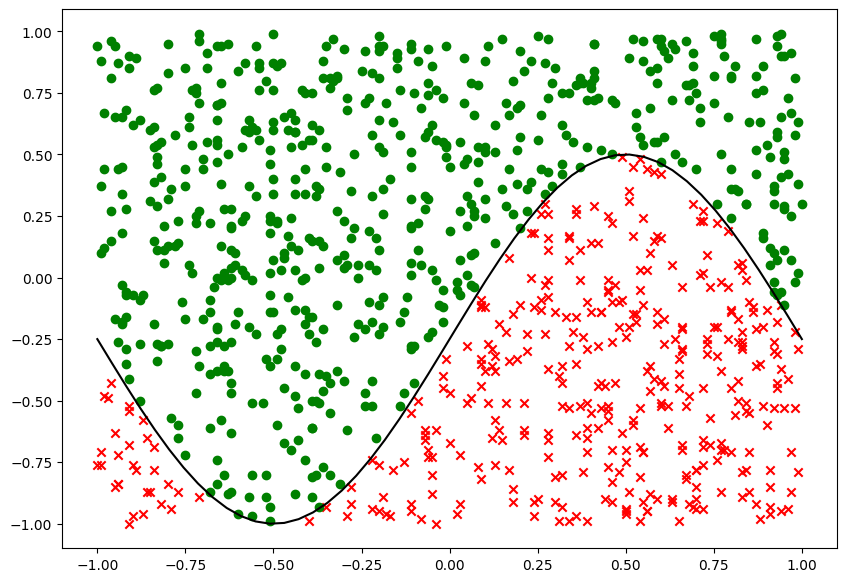

In [154]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.show()

### Our previous Shallow Neural Net class, with accuracies and an early stop on accuracies

Stochastic Mini-Batch

In [155]:
class ShallowNeuralNet():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        pred = [int(val >= 0.5) for val in self.forward(inputs)]
        acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
        return acc
    
    def backward(self, inputs, outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, inputs, outputs, N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        # List of losses, starts with the current loss
        self.losses_list = [self.CE_loss(inputs, outputs)]
        self.accuracies_list = [self.accuracy(inputs, outputs)]
        
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Define RNG for stochastic minibatches
        rng = default_rng()
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = inputs[shuffler, :]
            outputs_sub = outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
                
            # Update loss attribute on all losses
            self.loss = self.CE_loss(inputs, outputs)
            # Update losses list
            self.losses_list.append(self.loss)
            
            # Update accuracies
            acc = self.accuracy(inputs, outputs)
            self.accuracies_list.append(acc)
            
            # Display
            if(display and iteration_number % (N_max*0.05) == 1):
                print("Iteration {} - Loss = {} - Acc = {}".format(iteration_number, self.loss, acc))
            # Check for delta value and early stop criterion
            difference = abs(self.accuracies_list[-1] - self.accuracies_list[-2])
            if(difference < delta and self.accuracies_list[-1] > 0.98):
                if(display):
                    message = "Stopping early - accuracy evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
    
    def show_training_curves(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 3, figsize = (15, 7))
        axs[0].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Loss")
        axs[1].plot(list(range(len(self.losses_list))), self.losses_list)
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Loss (in logarithmic scale)")
        axs[1].set_yscale("log")
        axs[2].plot(list(range(len(self.accuracies_list))), self.accuracies_list)
        axs[2].set_xlabel("Iteration number")
        axs[2].set_ylabel("Accuracy")
        # Display
        plt.show()

In [161]:
# Define and train neural network structure (stochastic minibatch GD)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_stominibatch = ShallowNeuralNet(n_x, n_h, n_y)
# Train and show final loss (and time it)
shallow_neural_net_stominibatch.train(inputs, outputs, N_max = 500, alpha = 1e-1, beta1 = 0.9, \
                               beta2 = 0.999, delta = 1e-4, batch_size = 50, display = True)
print(shallow_neural_net_stominibatch.loss)

Iteration 1 - Loss = 0.6561800987929671 - Acc = 0.626
Iteration 26 - Loss = 0.27678251139630783 - Acc = 0.871
Iteration 51 - Loss = 0.2756804356289158 - Acc = 0.868
Iteration 76 - Loss = 0.27962969775406 - Acc = 0.868
Iteration 101 - Loss = 0.27331181164086754 - Acc = 0.873
Iteration 126 - Loss = 0.25487728599297915 - Acc = 0.883
Iteration 151 - Loss = 0.23263156045695665 - Acc = 0.898
Iteration 176 - Loss = 0.21584422101309694 - Acc = 0.901
Iteration 201 - Loss = 0.21665354050855867 - Acc = 0.919
Iteration 226 - Loss = 0.19135082195901482 - Acc = 0.916
Iteration 251 - Loss = 0.17593729206084285 - Acc = 0.923
Iteration 276 - Loss = 0.1536584650879999 - Acc = 0.94
Iteration 301 - Loss = 0.1483052312363991 - Acc = 0.947
Iteration 326 - Loss = 0.1336143888993969 - Acc = 0.971
Iteration 351 - Loss = 0.12229519074533794 - Acc = 0.962
Iteration 376 - Loss = 0.1091662003672586 - Acc = 0.972
Iteration 401 - Loss = 0.10941395110883526 - Acc = 0.971
Iteration 426 - Loss = 0.09408614857491719 - A

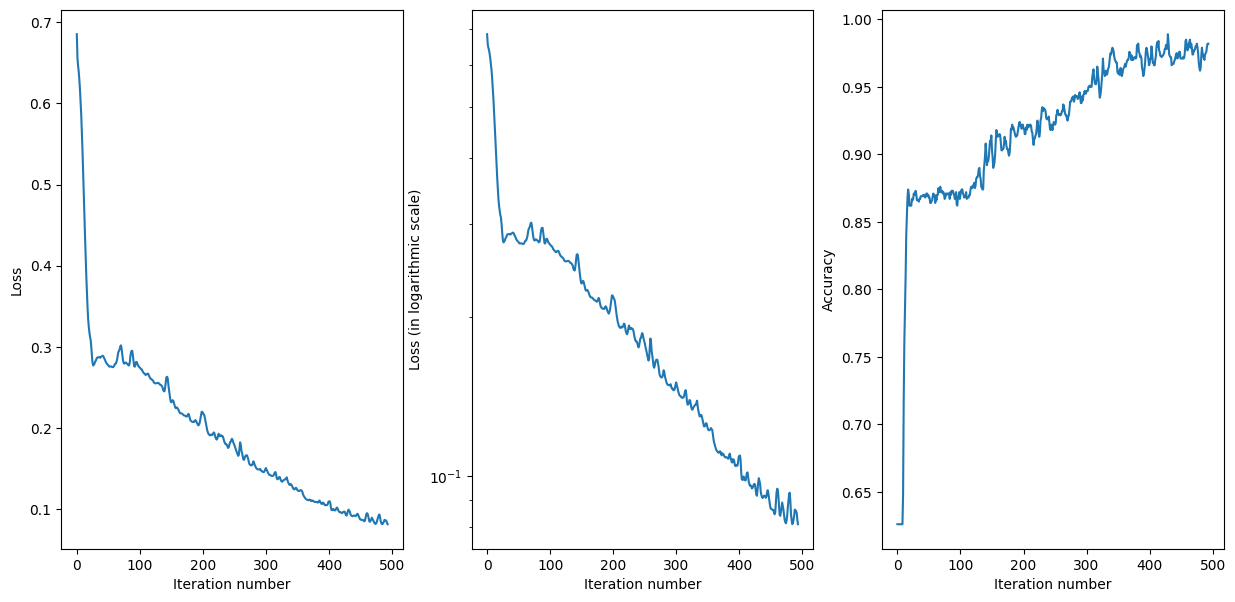

In [162]:
shallow_neural_net_stominibatch.show_training_curves()

### Train, test and validation sets

...

In [163]:
# Generate dataset (train)
np.random.seed(47)
n_points_train = 1000
train_val1_list, train_val2_list, train_inputs, train_outputs = create_dataset(n_points_train, min_val, max_val)
print(train_inputs.shape)
print(train_outputs.shape)

(1000, 2)
(1000, 1)


In [164]:
# Generate dataset (test)
np.random.seed(17)
n_points_test = 100
test_val1_list, test_val2_list, test_inputs, test_outputs = create_dataset(n_points_test, min_val, max_val)
print(test_inputs.shape)
print(test_outputs.shape)

(100, 2)
(100, 1)


In [165]:
# Generate dataset (valid)
np.random.seed(27)
n_points_valid = 100
valid_val1_list, valid_val2_list, valid_inputs, valid_outputs = create_dataset(n_points_valid, min_val, max_val)
# Check a few entries of the dataset
print(valid_inputs.shape)
print(valid_outputs.shape)

(100, 2)
(100, 1)


As expected and observed in the plots below, the dataset now longer exhibits linearity. In fact the function is no longer polynomial either due to the presence of a logarithmic function.

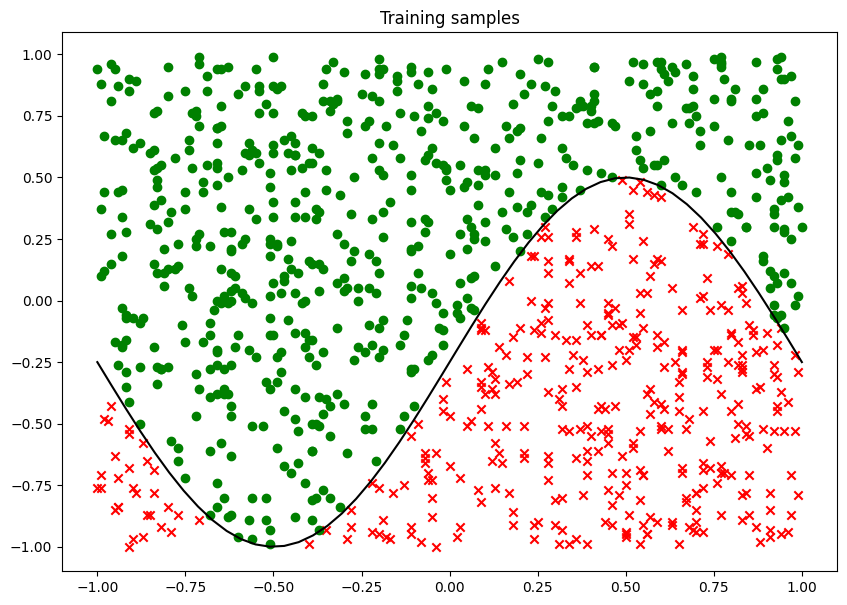

In [166]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(train_outputs == 0)[0]
v1_0 = train_val1_list[indexes_0]
v2_0 = train_val2_list[indexes_0]
indexes_1 = np.where(train_outputs == 1)[0]
v1_1 = train_val1_list[indexes_1]
v2_1 = train_val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.title("Training samples")
plt.show()

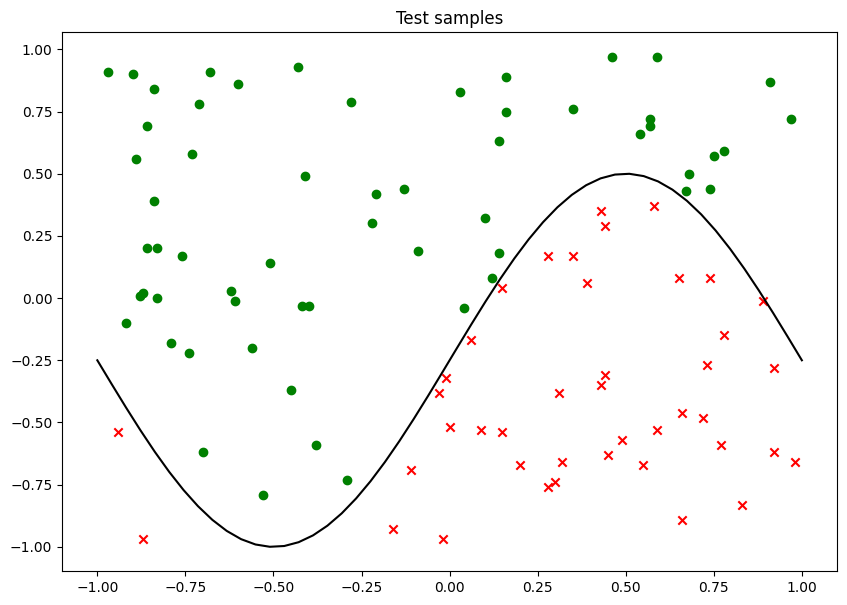

In [167]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(test_outputs == 0)[0]
v1_0 = test_val1_list[indexes_0]
v2_0 = test_val2_list[indexes_0]
indexes_1 = np.where(test_outputs == 1)[0]
v1_1 = test_val1_list[indexes_1]
v2_1 = test_val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.title("Test samples")
plt.show()

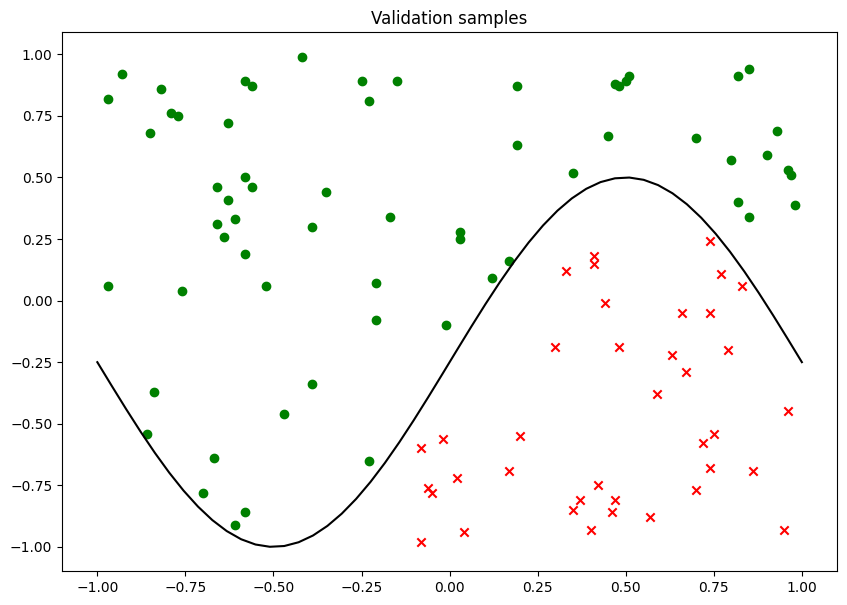

In [169]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "r", 1: "g"}
indexes_0 = np.where(valid_outputs == 0)[0]
v1_0 = valid_val1_list[indexes_0]
v2_0 = valid_val2_list[indexes_0]
indexes_1 = np.where(valid_outputs == 1)[0]
v1_1 = valid_val1_list[indexes_1]
v2_1 = valid_val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])
    
# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary")

# Show
plt.title("Validation samples")
plt.show()

### Our previous Shallow Neural Net class, with accuracies and an early stop on accuracies

Stochastic Mini-Batch

In [176]:
class ShallowNeuralNet_TTVsets():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        pred = [int(val >= 0.5) for val in self.forward(inputs)]
        acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
        return acc
    
    def backward(self, train_inputs, train_outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, train_inputs, train_outputs, test_inputs, test_outputs, valid_inputs, valid_outputs, \
              N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        # List of losses and accuracies
        self.train_losses_list = [self.CE_loss(train_inputs, train_outputs)]
        self.train_accuracies_list = [self.accuracy(train_inputs, train_outputs)]
        self.test_losses_list = [self.CE_loss(test_inputs, test_outputs)]
        self.test_accuracies_list = [self.accuracy(test_inputs, test_outputs)]
        
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Define RNG for stochastic minibatches
        rng = default_rng()
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = train_inputs[shuffler, :]
            outputs_sub = train_outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
            
            if(display and iteration_number % (N_max*0.05) == 1):
                # Update losses list
                train_loss = self.CE_loss(train_inputs, train_outputs)
                self.train_losses_list.append(train_loss)
                test_loss = self.CE_loss(test_inputs, test_outputs)
                self.test_losses_list.append(test_loss)

                # Update accuracies
                train_acc = self.accuracy(train_inputs, train_outputs)
                self.train_accuracies_list.append(train_acc)
                test_acc = self.accuracy(test_inputs, test_outputs)
                self.test_accuracies_list.append(test_acc)
                
                # Display
                message = "Iteration {} ".format(iteration_number)
                message += "\n - Train Loss = {} - Train Acc = {}".format(train_loss, train_acc)
                message += "\n - Test Loss = {} - Test Acc = {}".format(test_loss, test_acc)
                print(message)
            """
            # Check for delta value and early stop criterion
            difference = abs(self.test_accuracies_list[-1] - self.test_accuracies_list[-2])
            if(difference < delta and self.test_accuracies_list[-1] > 0.98):
                if(display):
                    message = "Stopping early - accuracy evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
            """
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
                
        # Display Accuracy on validation
        print("Validation accuracy = {}".format(self.accuracy(valid_inputs, valid_outputs)))
    
    def show_training_curves(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 3, figsize = (15, 7))
        axs[0].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[0].plot(list(range(len(self.test_losses_list))), \
                    self.test_losses_list, "r--", \
                    label = "Test loss")
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Losses")
        axs[1].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[1].plot(list(range(len(self.test_losses_list))), \
                    self.test_losses_list, "r--", \
                    label = "Train loss")
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Losses (in logarithmic scale)")
        axs[1].set_yscale("log")
        axs[2].plot(list(range(len(self.train_accuracies_list))), \
                    self.train_accuracies_list, "b--", \
                    label = "Acc loss")
        axs[2].plot(list(range(len(self.test_accuracies_list))), \
                    self.test_accuracies_list, "r--", \
                    label = "Acc loss")
        axs[2].set_xlabel("Iteration number")
        axs[2].set_ylabel("Accuracies")
        # Display
        axs[0].legend(loc = "best")
        axs[1].legend(loc = "best")
        axs[2].legend(loc = "best")
        plt.show()

In [177]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv = ShallowNeuralNet_TTVsets(n_x, n_h, n_y)
# Train and show final loss (and time it)
shallow_neural_net_ttv.train(train_inputs, train_outputs, test_inputs, test_outputs, \
                             valid_inputs, valid_outputs, N_max = 1000, alpha = 1e-1, \
                             beta1 = 0.9, beta2 = 0.999, delta = 1e-4, batch_size = 50, display = True)

Iteration 1 
 - Train Loss = 0.6561840401736492 - Train Acc = 0.626
 - Test Loss = 0.6868724257272061 - Test Acc = 0.58
Iteration 51 
 - Train Loss = 0.27246417839077974 - Train Acc = 0.872
 - Test Loss = 0.2458862848249715 - Test Acc = 0.88
Iteration 101 
 - Train Loss = 0.21475067800557476 - Train Acc = 0.925
 - Test Loss = 0.1955795089321783 - Test Acc = 0.92
Iteration 151 
 - Train Loss = 0.13606386547676239 - Train Acc = 0.958
 - Test Loss = 0.13169018522517176 - Test Acc = 0.98
Iteration 201 
 - Train Loss = 0.07783865427758681 - Train Acc = 0.991
 - Test Loss = 0.07347642834989897 - Test Acc = 1.0
Iteration 251 
 - Train Loss = 0.05506050057388396 - Train Acc = 0.993
 - Test Loss = 0.049145825792553194 - Test Acc = 1.0
Iteration 301 
 - Train Loss = 0.04489516822226243 - Train Acc = 0.993
 - Test Loss = 0.03902523059796362 - Test Acc = 1.0
Iteration 351 
 - Train Loss = 0.03876451211480143 - Train Acc = 0.995
 - Test Loss = 0.03385745784141765 - Test Acc = 1.0
Iteration 401 
 - 

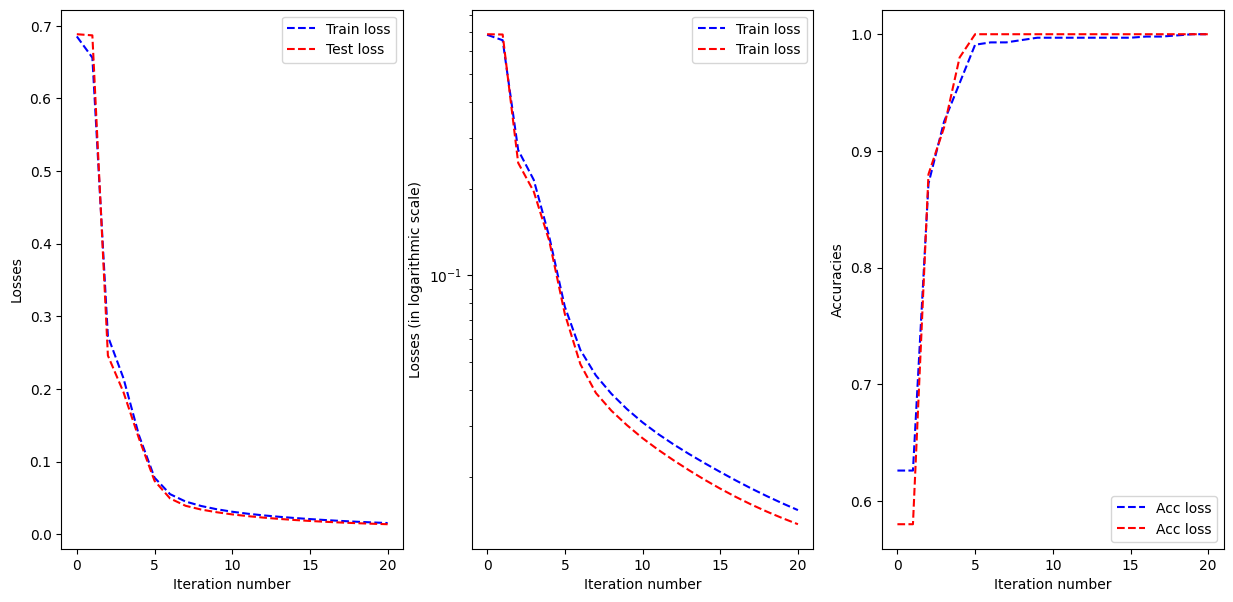

In [178]:
shallow_neural_net_ttv.show_training_curves()

In [188]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv2 = ShallowNeuralNet_TTVsets(n_x, n_h, n_y)
# Train and show final loss (and time it)
shallow_neural_net_ttv2.train(train_inputs, train_outputs, test_inputs, test_outputs, \
                             valid_inputs, valid_outputs, N_max = 40, alpha = 1e-1, \
                             beta1 = 0.9, beta2 = 0.999, delta = 1e-4, batch_size = 50, display = True)

Iteration 1 
 - Train Loss = 0.6561840401736492 - Train Acc = 0.626
 - Test Loss = 0.6868724257272061 - Test Acc = 0.58
Iteration 3 
 - Train Loss = 0.6459417970512065 - Train Acc = 0.626
 - Test Loss = 0.684675712471065 - Test Acc = 0.58
Iteration 5 
 - Train Loss = 0.6137774213366376 - Train Acc = 0.626
 - Test Loss = 0.6346886164851085 - Test Acc = 0.58
Iteration 7 
 - Train Loss = 0.5893540152074538 - Train Acc = 0.644
 - Test Loss = 0.6002167963857803 - Test Acc = 0.59
Iteration 9 
 - Train Loss = 0.5371609455510143 - Train Acc = 0.736
 - Test Loss = 0.548025102519046 - Test Acc = 0.67
Iteration 11 
 - Train Loss = 0.4766834168246668 - Train Acc = 0.798
 - Test Loss = 0.48779655525020277 - Test Acc = 0.78
Iteration 13 
 - Train Loss = 0.41931020529755053 - Train Acc = 0.851
 - Test Loss = 0.4234409981775225 - Test Acc = 0.86
Iteration 15 
 - Train Loss = 0.3719181918048897 - Train Acc = 0.87
 - Test Loss = 0.36255257232322774 - Test Acc = 0.88
Iteration 17 
 - Train Loss = 0.33714

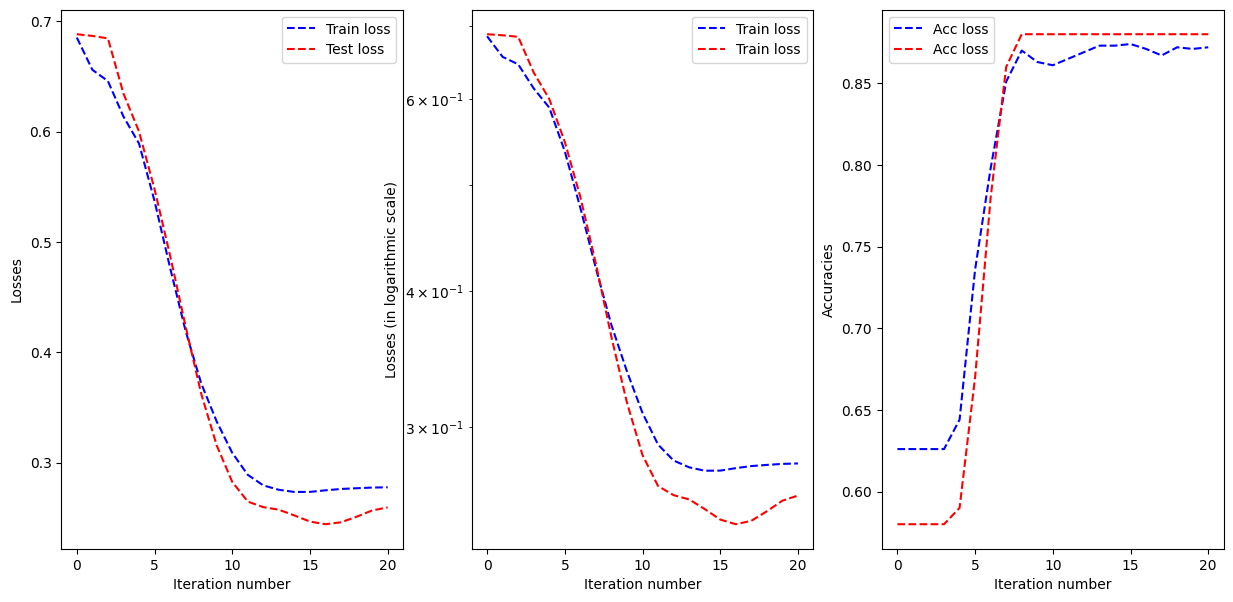

In [189]:
shallow_neural_net_ttv2.show_training_curves()

### Visualization

...

In [191]:
def find_v2(v1, model, min_val, max_val, thr = 1e-3):
    # Dichotomic search, to be used for boundary drawing later
    v2_min = min_val
    v2_max = max_val
    while((v2_max - v2_min) > thr):
        v2_avg = (v2_max + v2_min)/2
        out = model.forward([v1, v2_avg])
        if(out > 0.5):
            v2_max = v2_avg
        else:
            v2_min = v2_avg
    return (v2_max + v2_min)/2

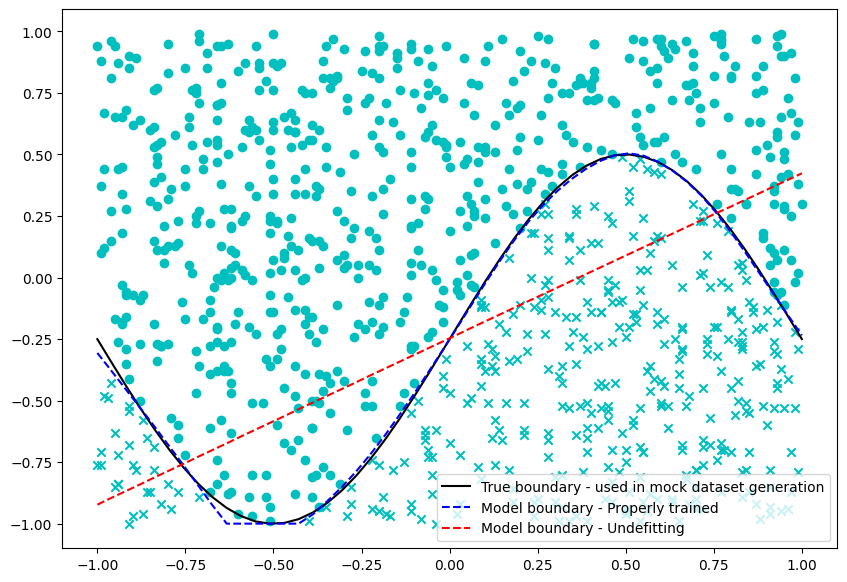

In [192]:
# Initialize plot
fig = plt.figure(figsize = (10, 7))

# Scatter plot
markers = {0: "x", 1: "o"}
colors = {0: "c", 1: "c"}
indexes_0 = np.where(outputs == 0)[0]
v1_0 = val1_list[indexes_0]
v2_0 = val2_list[indexes_0]
indexes_1 = np.where(outputs == 1)[0]
v1_1 = val1_list[indexes_1]
v2_1 = val2_list[indexes_1]
plt.scatter(v1_0, v2_0, c = colors[0], marker = markers[0])
plt.scatter(v1_1, v2_1, c = colors[1], marker = markers[1])

# Display true boundary
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_true = [-1/4 + 3/4*np.sin(v1*np.pi) for v1 in x1]
plt.plot(x1, x2_true, "k", label = "True boundary - used in mock dataset generation")

# Display model boundary (properly trained)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_batch = [find_v2(v1, shallow_neural_net_ttv, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_batch, "b--", label = "Model boundary - Properly trained")

# Display model boundary (properly trained)
x1 = [v1 for v1 in np.linspace(min_val, max_val, 50)]
x2_batch = [find_v2(v1, shallow_neural_net_ttv2, min_val, max_val, thr = 1e-3) for v1 in x1]
plt.plot(x1, x2_batch, "r--", label = "Model boundary - Undefitting")

# Show
plt.legend(loc = "best")
plt.show()

### Saver and loader functions

...

In [238]:
class ShallowNeuralNet_save():
    
    def __init__(self, n_x, n_h, n_y):
        # Network dimensions
        self.n_x = n_x
        self.n_h = n_h
        self.n_y = n_y
        # Initialize parameters
        self.init_parameters_normal()
        # Loss, initialized as infinity before first calculation is made
        self.loss = float("Inf")
         
    def init_parameters_normal(self):
        # Weights and biases matrices (randomly initialized)
        self.W1 = np.random.randn(self.n_x, self.n_h)*0.1
        self.b1 = np.random.randn(1, self.n_h)*0.1
        self.W2 = np.random.randn(self.n_h, self.n_y)*0.1
        self.b2 = np.random.randn(1, self.n_y)*0.1

    def sigmoid(self, val):
        return 1/(1 + np.exp(-val))
    
    def forward(self, inputs):
        # Wx + b operation for the first layer
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        # Wx + b operation for the second layer
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
        return y_pred
    
    def CE_loss(self, inputs, outputs):
        # MSE loss function as before
        outputs_re = outputs.reshape(-1, 1)
        pred = self.forward(inputs)
        eps = 1e-10
        losses = outputs*np.log(pred + eps) + (1 - outputs)*np.log(1 - pred + eps)
        loss = -np.sum(losses)/outputs.shape[0]
        return loss
    
    def accuracy(self, inputs, outputs):
        # Calculate accuracy for given inputs and ouputs
        pred = [int(val >= 0.5) for val in self.forward(inputs)]
        acc = sum([int(val1 == val2[0]) for val1, val2 in zip(pred, outputs)])/outputs.shape[0]
        return acc
    
    def backward(self, train_inputs, train_outputs, G_list, iteration_number, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999):
        # Get the number of samples in dataset
        m = inputs.shape[0]
        
        # Forward propagate
        Z1 = np.matmul(inputs, self.W1)
        Z1_b = Z1 + self.b1
        A1 = self.sigmoid(Z1_b)
        Z2 = np.matmul(A1, self.W2)
        Z2_b = Z2 + self.b2
        y_pred = self.sigmoid(Z2_b)
    
        # Compute error term
        epsilon = y_pred - outputs
        gradient_output = epsilon*y_pred*(1 - y_pred)
        error_hidden = np.dot(gradient_output, self.W2.T)
        gradient_hidden = error_hidden*A1*(1 - A1)
        
        # Compute gradients
        grad_W2 = -(1/m)*np.dot(A1.T, gradient_output)
        grad_W1 = -(1/m)*np.dot(inputs.T, gradient_hidden)
        grad_b2 = -(1/m)*np.sum(gradient_output, axis = 0, keepdims = True)
        grad_b1 = -(1/m)*np.sum(gradient_hidden, axis = 0, keepdims = True)
        
        # Momentum and gradient decay/normalization for each parameter
        V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1 = G_list
        V_W2 = beta1*V_W2 + (1 - beta1)*grad_W2
        V_W1 = beta1*V_W1 + (1 - beta1)*grad_W1
        V_b2 = beta1*V_b2 + (1 - beta1)*grad_b2
        V_b1 = beta1*V_b1 + (1 - beta1)*grad_b1
        V_W2_norm = V_W2/(1 - beta1**iteration_number)
        V_W1_norm = V_W1/(1 - beta1**iteration_number)
        V_b2_norm = V_b2/(1 - beta1**iteration_number)
        V_b1_norm = V_b1/(1 - beta1**iteration_number)
        S_W2 = beta2*S_W2 + (1 - beta2)*grad_W2**2
        S_W1 = beta2*S_W1 + (1 - beta2)*grad_W1**2
        S_b2 = beta2*S_b2 + (1 - beta2)*grad_b2**2
        S_b1 = beta2*S_b1 + (1 - beta2)*grad_b1**2
        S_W2_norm = S_W2/(1 - beta2**iteration_number)
        S_W1_norm = S_W1/(1 - beta2**iteration_number)
        S_b2_norm = S_b2/(1 - beta2**iteration_number)
        S_b1_norm = S_b1/(1 - beta2**iteration_number)
        G_list = [V_W2, V_W1, V_b2, V_b1, S_W2, S_W1, S_b2, S_b1]
        
        # Gradient descent update rules
        eps = 1e-6
        self.W2 += alpha*V_W2_norm/(np.sqrt(S_W2_norm) + eps)
        self.W1 += alpha*V_W1_norm/(np.sqrt(S_W1_norm) + eps)
        self.b2 += alpha*V_b2_norm/(np.sqrt(S_b2_norm) + eps)
        self.b1 += alpha*V_b1_norm/(np.sqrt(S_b1_norm) + eps)
        
        # Update loss
        loss = self.CE_loss(inputs, outputs)
        return G_list, loss
    
    def train(self, train_inputs, train_outputs, test_inputs, test_outputs, valid_inputs, valid_outputs, \
              N_max = 1000, alpha = 1e-5, beta1 = 0.9, beta2 = 0.999, \
              delta = 1e-5, batch_size = 100, display = True):
        # Get number of samples
        M = inputs.shape[0]
        # List of losses and accuracies
        self.train_losses_list = [self.CE_loss(train_inputs, train_outputs)]
        self.train_accuracies_list = [self.accuracy(train_inputs, train_outputs)]
        self.test_losses_list = [self.CE_loss(test_inputs, test_outputs)]
        self.test_accuracies_list = [self.accuracy(test_inputs, test_outputs)]
        
        # Initialize G_list
        G_list = [0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1, \
                  0*self.W2, 0*self.W1, 0*self.b2, 0*self.b1]
        # Define RNG for stochastic minibatches
        rng = default_rng()
        # Repeat iterations
        for iteration_number in range(1, N_max + 1):
            # Select a subset of inputs and outputs with given batch size
            shuffler = rng.choice(M, size = batch_size, replace = False)
            inputs_sub = train_inputs[shuffler, :]
            outputs_sub = train_outputs[shuffler, :]
            
            # Backpropagate
            G_list, loss = self.backward(inputs_sub, outputs_sub, G_list, iteration_number, alpha, beta1, beta2)
            
            if(display and iteration_number % (N_max*0.05) == 1):
                # Update losses list
                train_loss = self.CE_loss(train_inputs, train_outputs)
                self.train_losses_list.append(train_loss)
                test_loss = self.CE_loss(test_inputs, test_outputs)
                self.test_losses_list.append(test_loss)

                # Update accuracies
                train_acc = self.accuracy(train_inputs, train_outputs)
                self.train_accuracies_list.append(train_acc)
                test_acc = self.accuracy(test_inputs, test_outputs)
                self.test_accuracies_list.append(test_acc)
                
                # Save model
                self.save("./save", iter_num = str(iteration_number))
                
                # Display
                message = "Iteration {} ".format(iteration_number)
                message += "\n - Train Loss = {} - Train Acc = {}".format(train_loss, train_acc)
                message += "\n - Test Loss = {} - Test Acc = {}".format(test_loss, test_acc)
                print(message)
            """
            # Check for delta value and early stop criterion
            difference = abs(self.test_accuracies_list[-1] - self.test_accuracies_list[-2])
            if(difference < delta and self.test_accuracies_list[-1] > 0.98):
                if(display):
                    message = "Stopping early - accuracy evolution was less than delta on"
                    message += "iteration {}.".format(iteration_number)
                    print(message)
                    break
            """
        else:
            # Else on for loop will execute if break did not trigger
            if(display):
                print("Stopping - Maximal number of iterations reached.")
                
        # Display Accuracy on validation
        print("Validation accuracy = {}".format(self.accuracy(valid_inputs, valid_outputs)))
        # Save final model
        self.save("./save")
    
    def show_training_curves(self):
        # Initialize matplotlib
        fig, axs = plt.subplots(1, 3, figsize = (15, 7))
        axs[0].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[0].plot(list(range(len(self.test_losses_list))), \
                    self.test_losses_list, "r--", \
                    label = "Test loss")
        axs[0].set_xlabel("Iteration number")
        axs[0].set_ylabel("Losses")
        axs[1].plot(list(range(len(self.train_losses_list))), \
                    self.train_losses_list, "b--", \
                    label = "Train loss")
        axs[1].plot(list(range(len(self.test_losses_list))), \
                    self.test_losses_list, "r--", \
                    label = "Train loss")
        axs[1].set_xlabel("Iteration number")
        axs[1].set_ylabel("Losses (in logarithmic scale)")
        axs[1].set_yscale("log")
        axs[2].plot(list(range(len(self.train_accuracies_list))), \
                    self.train_accuracies_list, "b--", \
                    label = "Acc loss")
        axs[2].plot(list(range(len(self.test_accuracies_list))), \
                    self.test_accuracies_list, "r--", \
                    label = "Acc loss")
        axs[2].set_xlabel("Iteration number")
        axs[2].set_ylabel("Accuracies")
        # Display
        axs[0].legend(loc = "best")
        axs[1].legend(loc = "best")
        axs[2].legend(loc = "best")
        plt.show()
        
    def save(self, path_to_file, iter_num = "final"):
        # Display
        folder = path_to_file + "/" + iter_num + "/"
        print("Saving model to", folder)
        
        # Check if directory exists
        if(not os.path.exists(folder)):
            os.mkdir(folder)
        
        # Dump
        with open(folder + "W1.pkl", 'wb') as f:
            pickle.dump(self.W1, f)
        f.close()
        with open(folder + "W2.pkl", 'wb') as f:
            pickle.dump(self.W2, f)
        f.close()
        with open(folder + "b1.pkl", 'wb') as f:
            pickle.dump(self.b1, f)
        f.close()
        with open(folder + "b2.pkl", 'wb') as f:
            pickle.dump(self.b2, f)
        f.close()
        
    def load(self, path_to_file, iter_num = "final"):
        folder = path_to_file + "/" + iter_num + "/"
        print("Loading model from", folder)
        
        # Load
        with open(folder + "W1.pkl", 'rb') as f:
            self.W1 = pickle.load(f)
        f.close()
        with open(folder + "W2.pkl", 'rb') as f:
            self.W2 = pickle.load(f)
        f.close()
        with open(folder + "b1.pkl", 'rb') as f:
            self.b1 = pickle.load(f)
        f.close()
        with open(folder + "b2.pkl", 'rb') as f:
            self.b2 = pickle.load(f)
        f.close()

In [241]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv3 = ShallowNeuralNet_save(n_x, n_h, n_y)
# Train and show final loss (and time it)
shallow_neural_net_ttv3.train(train_inputs, train_outputs, test_inputs, test_outputs, \
                             valid_inputs, valid_outputs, N_max = 1000, alpha = 1e-1, \
                             beta1 = 0.9, beta2 = 0.999, delta = 1e-4, batch_size = 50, display = True)

Saving model to ./save/1/
Iteration 1 
 - Train Loss = 0.6561840401736492 - Train Acc = 0.626
 - Test Loss = 0.6868724257272061 - Test Acc = 0.58
Saving model to ./save/51/
Iteration 51 
 - Train Loss = 0.27246417839077974 - Train Acc = 0.872
 - Test Loss = 0.2458862848249715 - Test Acc = 0.88
Saving model to ./save/101/
Iteration 101 
 - Train Loss = 0.21475067800557476 - Train Acc = 0.925
 - Test Loss = 0.1955795089321783 - Test Acc = 0.92
Saving model to ./save/151/
Iteration 151 
 - Train Loss = 0.13606386547676239 - Train Acc = 0.958
 - Test Loss = 0.13169018522517176 - Test Acc = 0.98
Saving model to ./save/201/
Iteration 201 
 - Train Loss = 0.07783865427758681 - Train Acc = 0.991
 - Test Loss = 0.07347642834989897 - Test Acc = 1.0
Saving model to ./save/251/
Iteration 251 
 - Train Loss = 0.05506050057388396 - Train Acc = 0.993
 - Test Loss = 0.049145825792553194 - Test Acc = 1.0
Saving model to ./save/301/
Iteration 301 
 - Train Loss = 0.04489516822226243 - Train Acc = 0.993


In [242]:
shallow_neural_net_ttv3.save("./save")

Saving model to ./save/final/


In [243]:
# Define and train neural network structure (TTV sets)
n_x = 2
n_h = 10
n_y = 1
np.random.seed(37)
shallow_neural_net_ttv4 = ShallowNeuralNet_save(n_x, n_h, n_y)
shallow_neural_net_ttv4.load("./save")
print((shallow_neural_net_ttv3.W1 == shallow_neural_net_ttv4.W1).all())

Loading model from ./save/final/
True


### What's next?

In the next notebook, we will investigate some additional variations on these optimizers, namely the early stopping and learning rate decays.